#### Data loading and visualization

In [1]:
#imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import numpy as np
import warnings
import os
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from PIL import Image
from skimage.feature import hog
from skimage.feature import hog
import random

In [2]:
#warnings, nope
warnings.filterwarnings("ignore", category=FutureWarning)
%autosave 30

Autosaving every 30 seconds



First 5 rows of train.csv:
                                         file_name  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


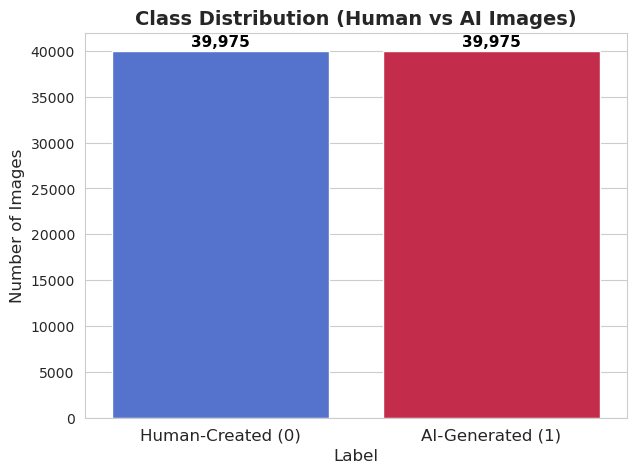

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset paths
DATASET_DIR = "/home/vsolomon3/AML-project/AHGI/train_data"  # Update with actual path
CSV_FILE = "/home/vsolomon3/AML-project/AHGI/train.csv"

# Load CSV file
df = pd.read_csv(CSV_FILE, index_col=0)

# Rename columns correctly
df.columns = ["file_name", "label"]

# Print the first few rows of train.csv
print("\nFirst 5 rows of train.csv:")
print(df.head())

# Extract only the filename (remove "train_data/" prefix)
df["file_name"] = df["file_name"].apply(lambda x: os.path.basename(x))

# Construct full image path
df["full_path"] = df["file_name"].apply(lambda x: os.path.join(DATASET_DIR, x))

# Convert label column to integer
df["label"] = df["label"].astype(int)

# Class Distribution
label_counts = df["label"].value_counts().sort_index()

# Plot Class Distribution
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=["royalblue", "crimson"])
plt.xticks(ticks=[0, 1], labels=["Human-Created (0)", "AI-Generated (1)"], fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xlabel("Label", fontsize=12)
plt.title("Class Distribution (Human vs AI Images)", fontsize=14, fontweight="bold")

# Add text labels on bars
for i, count in enumerate(label_counts.values):
    ax.text(i, count + 500, f"{count:,}", ha='center', fontsize=11, fontweight="bold", color="black")

plt.show()


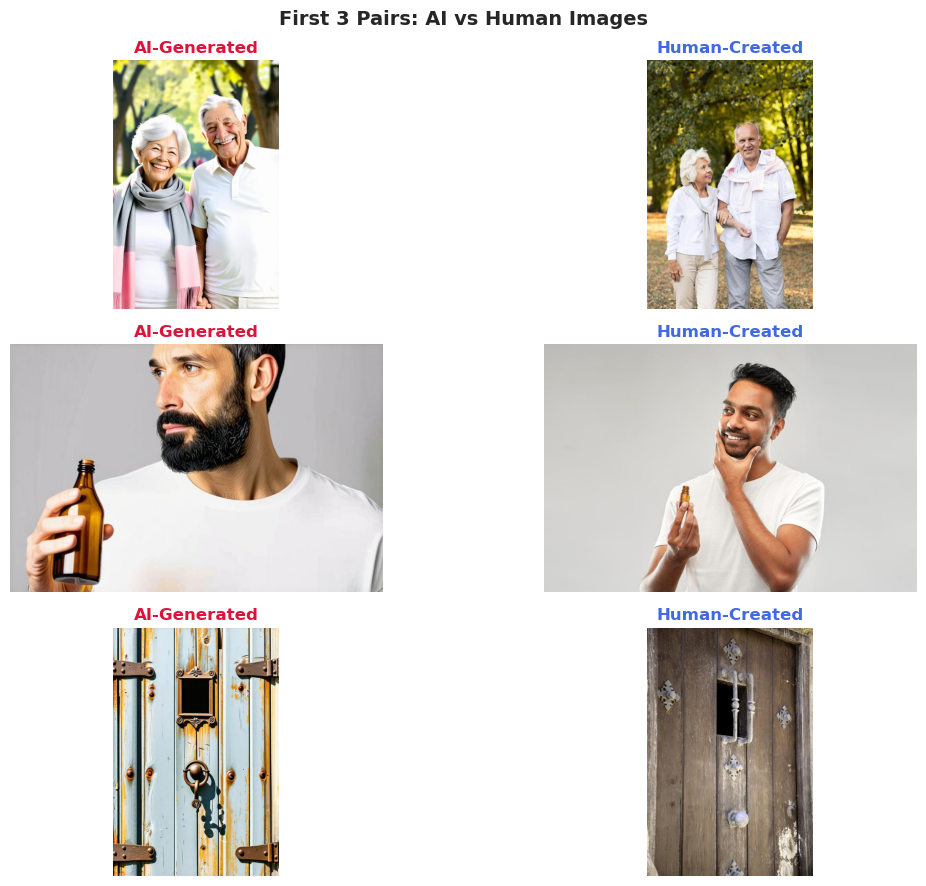

In [4]:

# Display First 3 Pairs of AI vs Human Images
def show_paired_images():
    """
    Displays the first 3 pairs of images: each AI-generated image placed next to its corresponding human-created image.
    """
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows, 2 columns

    # Select first 3 AI-Human pairs
    ai_images = df[df["label"] == 1].head(3)["full_path"].values  # First 3 AI images (Label 1)
    human_images = df[df["label"] == 0].head(3)["full_path"].values  # First 3 Human images (Label 0)

    for i in range(3):
        ai_img = Image.open(ai_images[i])  # Load AI image
        human_img = Image.open(human_images[i])  # Load Human image

        # AI-generated image (Left)
        axes[i, 0].imshow(ai_img)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("AI-Generated", fontsize=12, fontweight="bold", color="crimson")

        # Human-created image (Right)
        axes[i, 1].imshow(human_img)
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Human-Created", fontsize=12, fontweight="bold", color="royalblue")

    plt.suptitle("First 3 Pairs: AI vs Human Images", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Show the first 3 pairs of images
show_paired_images()


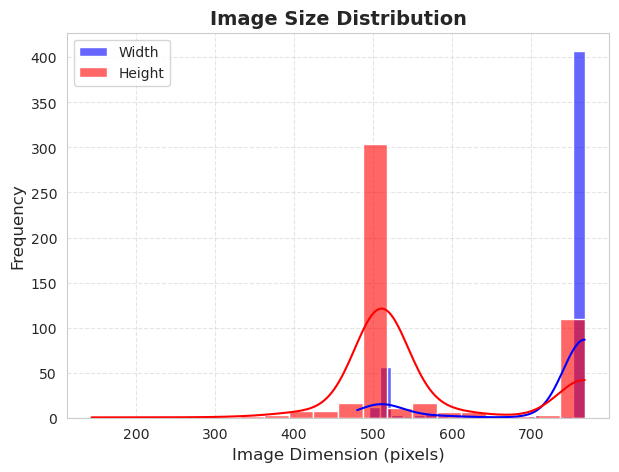

In [5]:

# Image Size Distribution Plot
image_shapes = []

# Sample 500 images for efficiency
sampled_images = df["full_path"].sample(500, random_state=42)

for img_path in sampled_images:
    try:
        img = Image.open(img_path).convert("RGB")  # Ensure image is in RGB mode
        image_shapes.append(img.size)  # (width, height)
    except Exception as e:
        print(f"Error loading image: {img_path} | {e}")

# Convert to DataFrame for visualization
image_sizes_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])

# Plot image size distribution
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

sns.histplot(image_sizes_df["Width"], bins=20, color="blue", label="Width", kde=True, alpha=0.6)
sns.histplot(image_sizes_df["Height"], bins=20, color="red", label="Height", kde=True, alpha=0.6)

plt.xlabel("Image Dimension (pixels)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Image Size Distribution", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Add grid lines

plt.show()


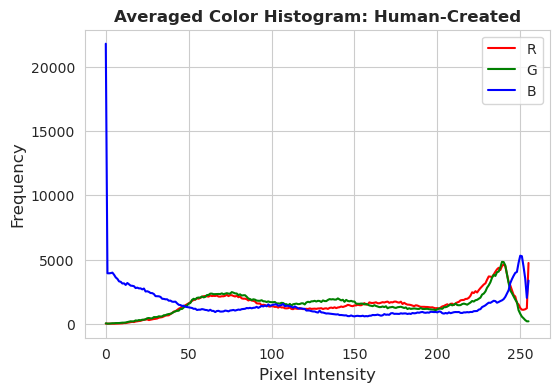

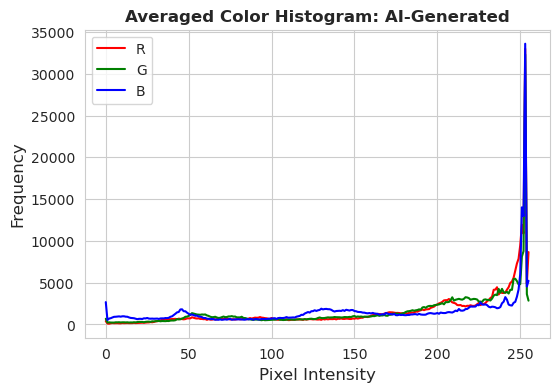

In [6]:
# Color Histogram Visualization
def plot_color_histogram(image_path, title):
    """
    Plots RGB color histogram for a given image.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    colors = ("r", "g", "b")
    plt.figure(figsize=(6, 4))
    for i, col in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        sns.lineplot(x=np.arange(256), y=hist.flatten(), color=col, label=col.upper())

    plt.title(f"Averaged Color Histogram: {title}", fontsize=12, fontweight="bold")
    plt.xlabel("Pixel Intensity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.show()

# Show color histogram of the first Human-created image (Label 0)
human_image_path = df[df["label"] == 0]["full_path"].iloc[0]  # Label 0 = Human
plot_color_histogram(human_image_path, "Human-Created")

# Show color histogram of the first AI-generated image (Label 1)
ai_image_path = df[df["label"] == 1]["full_path"].iloc[0]  # Label 1 = AI
plot_color_histogram(ai_image_path, "AI-Generated")

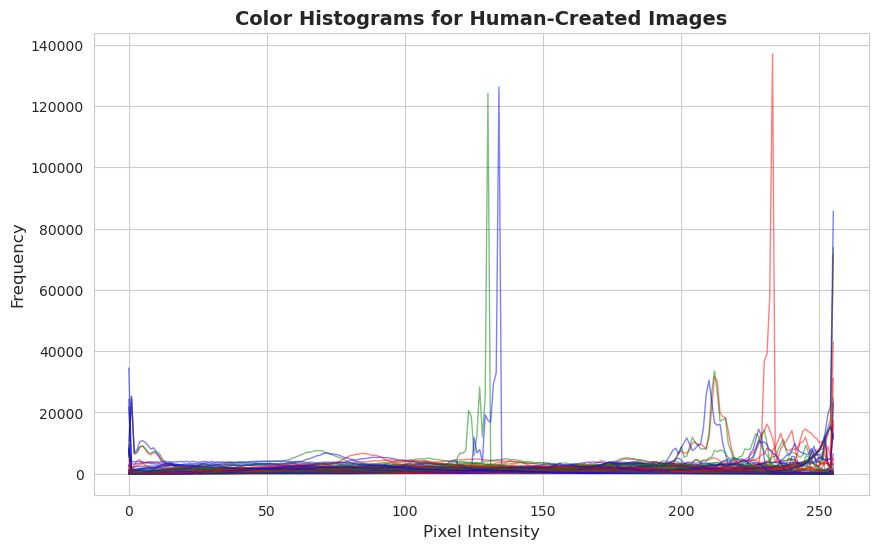

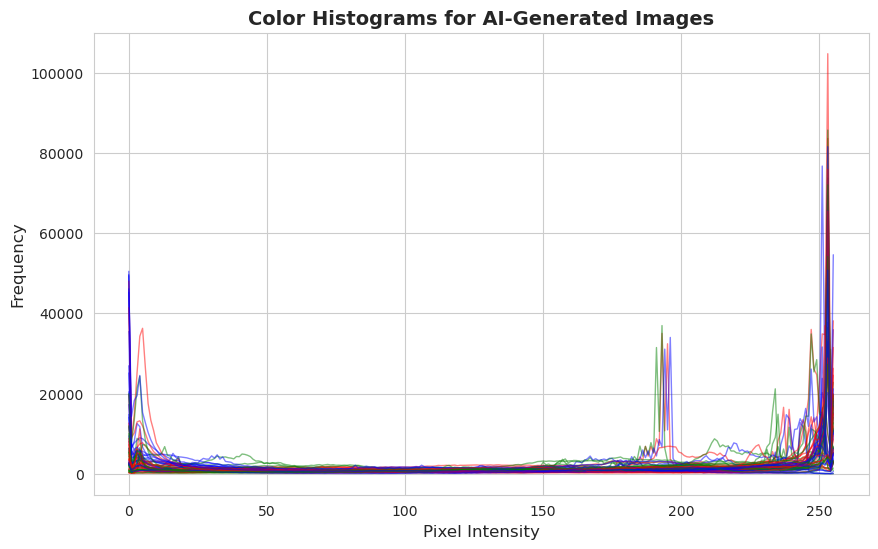

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  Function to plot color histograms for multiple images (overlay each one)
def plot_overlayed_histograms(image_paths, title, color_labels=("r", "g", "b")):
    """
    Plots RGB color histograms for multiple images, overlaying each image’s histogram.
    """
    plt.figure(figsize=(10, 6))

    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot histogram for each image (overlayed)
        for i, col in enumerate(color_labels):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            sns.lineplot(x=np.arange(256), y=hist.flatten(), color=col, alpha=0.5, linewidth=1)  # Lower alpha for visibility

    plt.title(f"Color Histograms for {title}", fontsize=14, fontweight="bold")
    plt.xlabel("Pixel Intensity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

# Select 20 AI-generated images and 20 Human-created images
num_samples = 20
human_image_paths = df[df["label"] == 0]["full_path"].iloc[:num_samples].tolist()  # Label 0 = Human
ai_image_paths = df[df["label"] == 1]["full_path"].iloc[:num_samples].tolist()  # Label 1 = AI

# Plot overlayed histograms for Human-created images
plot_overlayed_histograms(human_image_paths, "Human-Created Images")

# Plot overlayed histograms for AI-generated images
plot_overlayed_histograms(ai_image_paths, "AI-Generated Images")


#### preprocessing

In [8]:


#  Define transformation pipeline (without brightness adjustment)
transform = A.Compose([
    A.Resize(224, 224),                     # Resize to 224x224
    A.HorizontalFlip(p=0.5),                 # Randomly flip images horizontally
    A.RandomRotate90(p=0.5),                 # Random rotation (90-degree increments)
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
    ToTensorV2()                             # Convert to PyTorch Tensor
])

# Function to preprocess a single image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    augmented = transform(image=image)              # Apply transformations
    return augmented["image"]

# Preprocess all images in dataset
preprocessed_images = []
labels = []

# Iterate through dataset and apply preprocessing
for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing Images"):
    image_path = row["full_path"]
    label = row["label"]
    
    preprocessed_img = preprocess_image(image_path)  # Apply preprocessing
    preprocessed_images.append(preprocessed_img)
    labels.append(label)

#  Convert lists to NumPy arrays
X = np.stack(preprocessed_images)  # Image tensor
y = np.array(labels)  # Labels

# Print dataset shape
print(f"Processed dataset shape: {X.shape}, Labels shape: {y.shape}")  # (num_samples, 3, 224, 224)


Preprocessing Images: 100%|████████████████████████████████████████████| 79950/79950 [04:59<00:00, 267.15it/s]


Processed dataset shape: (79950, 3, 224, 224), Labels shape: (79950,)


#### feature engineering/ extraction

In [9]:
# Function to extract Canny Edge Features
def extract_canny_edges(image):
    """Extracts Canny edges from an image (grayscale)."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Convert to uint8 (0-255 range) since Canny requires 8-bit images
    gray = (gray * 255).astype(np.uint8)
    
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)  # Canny edge detection
    return edges  # Shape: (H, W)

# Function to extract HOG Features
def extract_hog_features(image):
    """Extracts Histogram of Oriented Gradients (HOG) features."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Convert to uint8 for HOG
    gray = (gray * 255).astype(np.uint8)
    
    # Compute HOG descriptor
    hog_features, hog_image = hog(gray, pixels_per_cell=(16, 16),
                                  cells_per_block=(2, 2),
                                  orientations=9,
                                  visualize=True,
                                  block_norm='L2-Hys')
    return hog_features, hog_image  # HOG vector & visualization

# Iterate through preprocessed dataset and extract features
edge_features = []
hog_features = []
hog_visuals = []

print("Extracting handcrafted features...")

for img_tensor in tqdm(X, total=len(X), desc="Feature Extraction"):
    img = np.transpose(img_tensor, (1, 2, 0))  # Convert (C, H, W) → (H, W, C)

    # Extract features
    edges = extract_canny_edges(img)
    hog_desc, hog_img = extract_hog_features(img)

    # Append to lists
    edge_features.append(edges)
    hog_features.append(hog_desc)
    hog_visuals.append(hog_img)

# Convert feature lists to NumPy arrays
edge_features = np.array(edge_features)  # Shape: (num_samples, H, W)
hog_features = np.array(hog_features)  # Shape: (num_samples, num_hog_features)

# Print feature shapes
print(f"Edge Features Shape: {edge_features.shape}")  # (num_samples, H, W)
print(f"HOG Features Shape: {hog_features.shape}")  # (num_samples, num_hog_features)

Extracting handcrafted features...


Feature Extraction: 100%|███████████████████████████████████████████████| 79950/79950 [42:48<00:00, 31.13it/s]


Edge Features Shape: (79950, 224, 224)
HOG Features Shape: (79950, 6084)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


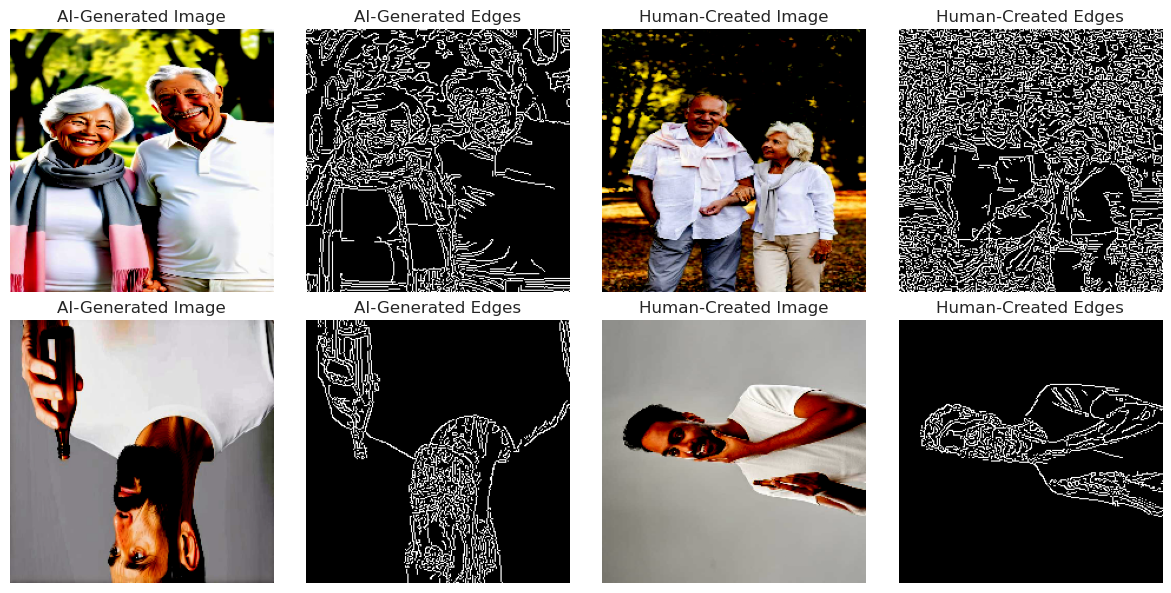

In [10]:
import matplotlib.pyplot as plt

# Function to visualize AI vs. Human images along with their edge maps
def visualize_ai_vs_human_edges():
    plt.figure(figsize=(12, 6))

    for i in range(2):  # Display first 2 pairs (AI + Human)
        ai_idx = i * 2  # AI Image index (labels alternate 0,1,0,1 in dataset)
        human_idx = ai_idx + 1  # Human counterpart index

        # AI Image
        plt.subplot(2, 4, i * 4 + 1)
        plt.imshow(np.transpose(X[ai_idx], (1, 2, 0)))
        plt.axis("off")
        plt.title("AI-Generated Image")

        # AI Edge Map
        plt.subplot(2, 4, i * 4 + 2)
        plt.imshow(edge_features[ai_idx], cmap="gray")
        plt.axis("off")
        plt.title("AI-Generated Edges")

        # Human Image (Counterpart)
        plt.subplot(2, 4, i * 4 + 3)
        plt.imshow(np.transpose(X[human_idx], (1, 2, 0)))
        plt.axis("off")
        plt.title("Human-Created Image")

        # Human Edge Map
        plt.subplot(2, 4, i * 4 + 4)
        plt.imshow(edge_features[human_idx], cmap="gray")
        plt.axis("off")
        plt.title("Human-Created Edges")

    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_ai_vs_human_edges()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


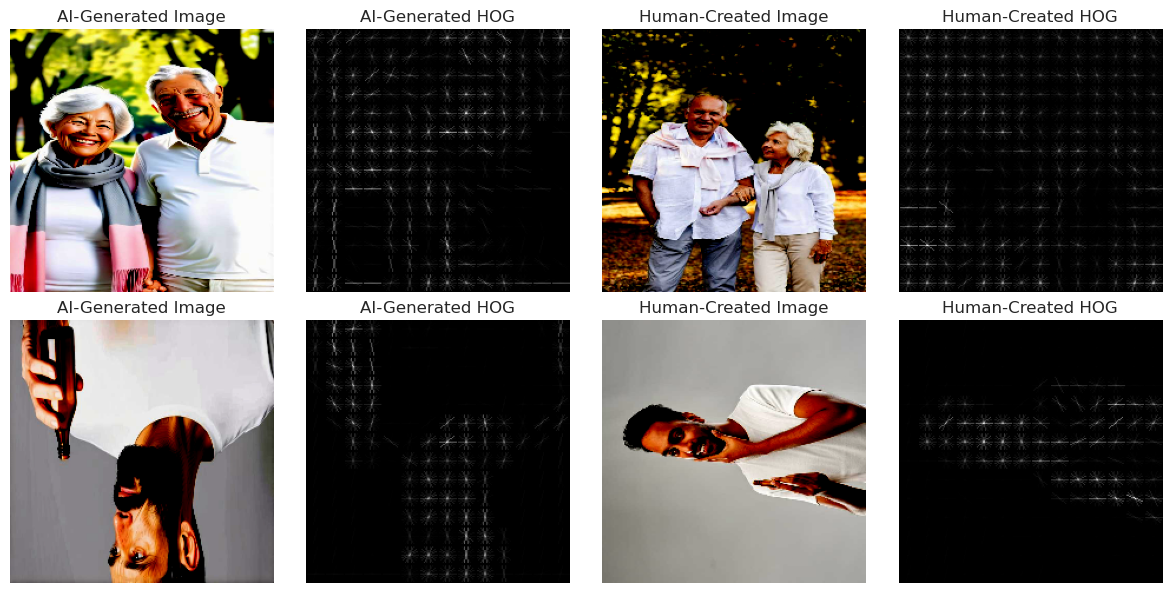

In [11]:

# Function to visualize AI vs. Human images along with their HOG visualizations
def visualize_ai_vs_human_hog():
    plt.figure(figsize=(12, 6))

    for i in range(2):  # Display first 2 pairs (AI + Human)
        ai_idx = i * 2  # AI Image index (labels alternate 0,1,0,1 in dataset)
        human_idx = ai_idx + 1  # Human counterpart index

        # AI Image
        plt.subplot(2, 4, i * 4 + 1)
        plt.imshow(np.transpose(X[ai_idx], (1, 2, 0)))
        plt.axis("off")
        plt.title("AI-Generated Image")

        # AI HOG Visualization
        plt.subplot(2, 4, i * 4 + 2)
        plt.imshow(hog_visuals[ai_idx], cmap="gray")
        plt.axis("off")
        plt.title("AI-Generated HOG")

        # Human Image (Counterpart)
        plt.subplot(2, 4, i * 4 + 3)
        plt.imshow(np.transpose(X[human_idx], (1, 2, 0)))
        plt.axis("off")
        plt.title("Human-Created Image")

        # Human HOG Visualization
        plt.subplot(2, 4, i * 4 + 4)
        plt.imshow(hog_visuals[human_idx], cmap="gray")
        plt.axis("off")
        plt.title("Human-Created HOG")

    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_ai_vs_human_hog()


#### training model

Epoch 1/1: 100%|██████████████████████████████████████████████████████████| 1999/1999 [28:51<00:00,  1.15it/s]


Epoch [1/1] - Loss: 0.2493 - Val Loss: 0.1780 - F1-Score: 0.9345


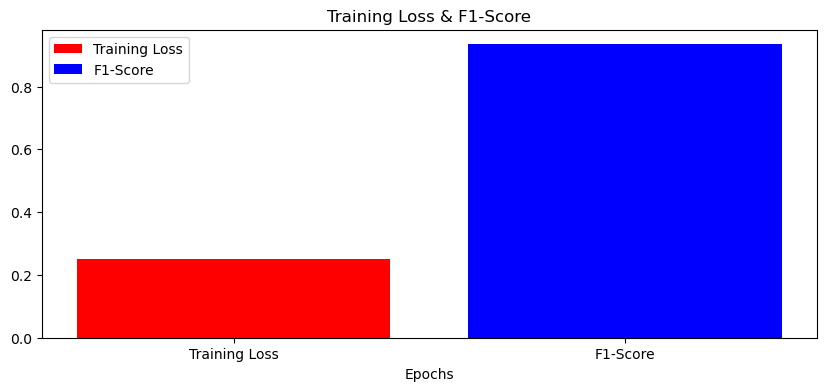

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.feature import hog
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# ==========================
# Define Preprocessing
# ==========================
transform = A.Compose([
    A.Resize(224, 224),                     
    A.HorizontalFlip(p=0.5),                
    A.RandomRotate90(p=0.5),                
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  
    ToTensorV2()                             
])

# ==========================
# Define Dataset Class
# ==========================
class ImageDataset(Dataset):
    def __init__(self, df, preprocess=True):
        self.df = df
        self.preprocess = preprocess
        self.hog_dim = 6084  # Fixed length for HOG feature vector

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["full_path"]
        label = self.df.iloc[idx]["label"] if "label" in self.df.columns else -1  # No labels in test set

        # Load and resize image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  

        # Apply transformations
        if self.preprocess:
            img = transform(image=img)["image"]

        # Convert PyTorch Tensor back to NumPy for feature extraction
        img_np = img.permute(1, 2, 0).cpu().numpy()  

        # Convert to grayscale for HOG
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

        # Compute HOG features
        hog_features = hog(gray, pixels_per_cell=(16, 16),
                           cells_per_block=(2, 2), orientations=9,
                           visualize=False, block_norm='L2-Hys')

        # Ensure fixed-length HOG vector
        hog_features = np.pad(hog_features, (0, max(0, self.hog_dim - len(hog_features))), mode='constant')[:self.hog_dim]

        # Convert to torch tensor
        hog_features = torch.tensor(hog_features, dtype=torch.float32)

        return img, hog_features, torch.tensor(label, dtype=torch.float32) if label != -1 else img_path

# ==========================
# Define CNN Model
# ==========================
class AIvsHumanCNN(nn.Module):
    def __init__(self, handcrafted_feature_dim):
        super(AIvsHumanCNN, self).__init__()
        
        # CNN Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adjusted for 224x224 input
        self.fc2 = nn.Linear(128 + handcrafted_feature_dim, 1)  # Feature fusion

    def forward(self, x, handcrafted_features):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        # Concatenate handcrafted features before final classification
        x = torch.cat((x, handcrafted_features), dim=1)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid output for binary classification
        
        return x

# ==========================
# Load Training Data
# ==========================
DATASET_DIR = "/home/vsolomon3/AML-project/AHGI/train_data"
CSV_FILE = "/home/vsolomon3/AML-project/AHGI/train.csv"

df = pd.read_csv(CSV_FILE, index_col=0)
df.columns = ["file_name", "label"]
df["file_name"] = df["file_name"].apply(lambda x: os.path.basename(x))
df["full_path"] = df["file_name"].apply(lambda x: os.path.join(DATASET_DIR, x))
df["label"] = df["label"].astype(int)

# Train-Validation Split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

# ==========================
# Create Data Loaders
# ==========================
batch_size = 32
train_dataset = ImageDataset(train_df)
val_dataset = ImageDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize Model
handcrafted_feature_dim = 6084  # Fixed HOG vector size
model = AIvsHumanCNN(handcrafted_feature_dim)

# Loss & Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ==========================
# Training Loop
# ==========================
train_losses = []
val_losses = []
f1_scores = []
epochs = 1  # You can set it to 1

def train_model(model, train_loader, val_loader, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        all_preds, all_labels = [], []

        for images, handcrafted, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            outputs = model(images, handcrafted)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation Step
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for images, handcrafted, labels in val_loader:
                outputs = model(images, handcrafted)
                val_loss += criterion(outputs, labels.unsqueeze(1)).item()

                predicted = (outputs > 0.5).float()
                val_preds.extend(predicted.cpu().numpy().flatten())
                val_labels.extend(labels.cpu().numpy().flatten())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        f1 = f1_score(val_labels, val_preds)
        f1_scores.append(f1)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Val Loss: {avg_val_loss:.4f} - F1-Score: {f1:.4f}")

# Train the Model
train_model(model, train_loader, val_loader, epochs)

# ==========================
# Plot Training Loss & F1-score
# ==========================
plt.figure(figsize=(10, 4))

if epochs == 1:
    plt.bar(["Training Loss"], train_losses, color="red", label="Training Loss")
    plt.bar(["F1-Score"], f1_scores, color="blue", label="F1-Score")
else:
    plt.plot(range(1, epochs+1), train_losses, marker="o", linestyle="-", color="red", label="Training Loss")
    plt.plot(range(1, epochs+1), f1_scores, marker="o", linestyle="-", color="blue", label="F1-Score")

plt.xlabel("Epochs")
plt.title("Training Loss & F1-Score")
plt.legend()
plt.show()


In [5]:
torch.save(model.state_dict(), "model.pth")
print(" Model saved as 'model.pth'")


 Model saved as 'model.pth'


In [6]:

# Define Preprocessing
# ==========================
transform = A.Compose([
    A.Resize(224, 224),                     
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  
    ToTensorV2()                             
])

# ==========================
# Define Dataset Class for Test Data
# ==========================
class TestImageDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.hog_dim = 6084  # Fixed length for HOG feature vector

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["full_path"]

        # Load and resize image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  

        # Apply transformations
        img = transform(image=img)["image"]

        # Convert PyTorch Tensor back to NumPy for feature extraction
        img_np = img.permute(1, 2, 0).cpu().numpy()  

        # Convert to grayscale for HOG
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

        # Compute HOG features
        hog_features = hog(gray, pixels_per_cell=(16, 16),
                           cells_per_block=(2, 2), orientations=9,
                           visualize=False, block_norm='L2-Hys')

        # Ensure fixed-length HOG vector
        hog_features = np.pad(hog_features, (0, max(0, self.hog_dim - len(hog_features))), mode='constant')[:self.hog_dim]

        # Convert to torch tensor
        hog_features = torch.tensor(hog_features, dtype=torch.float32)

        return img, hog_features, img_path

# ==========================
# Define CNN Model (Same as Training)
# ==========================
class AIvsHumanCNN(nn.Module):
    def __init__(self, handcrafted_feature_dim):
        super(AIvsHumanCNN, self).__init__()
        
        # CNN Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adjusted for 224x224 input
        self.fc2 = nn.Linear(128 + handcrafted_feature_dim, 1)  # Feature fusion

    def forward(self, x, handcrafted_features):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))

        # Concatenate handcrafted features before final classification
        x = torch.cat((x, handcrafted_features), dim=1)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid output for binary classification
        
        return x

# ==========================
# Load Test Data
# ==========================
TEST_DIR = "/home/vsolomon3/AML-project/AHGI/test_data_v2"
TEST_CSV = "/home/vsolomon3/AML-project/AHGI/test.csv"

test_df = pd.read_csv(TEST_CSV)
test_df["file_name"] = test_df["id"].apply(lambda x: os.path.basename(x))  # Extract only the image name
test_df["full_path"] = test_df["file_name"].apply(lambda x: os.path.join(TEST_DIR, x))

# ==========================
# Create Data Loader for Test Set
# ==========================
batch_size = 1  # Batch size 1 for making individual predictions
test_dataset = TestImageDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the Trained Model
handcrafted_feature_dim = 6084  # Fixed HOG vector size
model = AIvsHumanCNN(handcrafted_feature_dim)
model.load_state_dict(torch.load("model.pth"))  # Load the trained model
model.eval()

# ==========================
# Model Prediction on Test Data
# ==========================
predictions = []

with torch.no_grad():
    for images, handcrafted, img_paths in tqdm(test_loader, desc="Predicting"):
        output = model(images, handcrafted)
        predicted_label = (output > 0.5).float().item()

        # Ensure correct format: "test_data_v2/image_name.jpg"
        img_name = f"test_data_v2/{os.path.basename(img_paths[0])}"
        predictions.append([img_name, int(predicted_label)])

# ==========================
# Save Predictions to CSV (test.csv)
# ==========================
submission_df = pd.DataFrame(predictions, columns=["id", "label"])
submission_df.to_csv("test.csv", index=False)

print("\n Submission file 'test.csv' saved successfully!")


Predicting: 100%|█████████████████████████████████████████████████████████| 5540/5540 [03:50<00:00, 23.99it/s]


 Submission file 'test.csv' saved successfully!
